# Merge Datasets and Analysis

# General

## Imports

In [105]:
import os
import pandas as pd
import seaborn as sns


## Constants

In [61]:
PATH_PROTECED_AREA = 'data/OECD/protected_areas_2020.csv'
PATH_LAND_COVER = 'data/OECD/LAND_COVER_2018_DATA.csv'
PATH_AIR = ''
PATH_CLIMATE = 'data/climate/climate_features.csv'
PATH_IUCN = 'data/IUCN/scraped'
PATHS_COUN = [PATH_PROTECED_AREA, PATH_LAND_COVER, PATH_CLIMATE] # AIR IS MISSING

# IUCN Data

## Load and Concatenate

In [23]:
iucn_list = []
for _, _, files in os.walk(PATH_IUCN):
    for file in files:
        temp = pd.read_csv(PATH_IUCN + '/' + file)
        temp['Country'] = file.split('.csv')[0]
        iucn_list.append(temp)
iucn_data = pd.concat(iucn_list)

## Analysis

### General Information

In [25]:
iucn_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1006 entries, 0 to 27
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   kingdom_class    1006 non-null   object
 1   common_name      692 non-null    object
 2   scientific_name  1006 non-null   object
 3   trend            579 non-null    object
 4   region           1006 non-null   object
 5   threat_level     1006 non-null   object
 6   Country          1006 non-null   object
dtypes: object(7)
memory usage: 62.9+ KB


### Check Uniue Values

In [56]:
for c in iucn_data.columns:
    print('Column >>{}<< contains {} unique values.'.format(c, iucn_data[c].nunique()))

Column >>kingdom_class<< contains 14 unique values.
Column >>common_name<< contains 484 unique values.
Column >>scientific_name<< contains 754 unique values.
Column >>trend<< contains 4 unique values.
Column >>region<< contains 4 unique values.
Column >>threat_level<< contains 9 unique values.
Column >>Country<< contains 29 unique values.


### Explore Columns Containing NULL Values

#### common_name

In [31]:
print('common_name contains {} unique values.'.format(
    iucn_data['common_name'].nunique()))

common_name contains 484 unique values.


In [33]:
print('{} entries have missing values for the common_name column.'.format(
    iucn_data['common_name'].isna().sum()))

314 entries have missing values for the common_name column.


In [38]:
i_null_cn = iucn_data[iucn_data['common_name'].isna()].index

--> These missing values can probably be neglected, because we can use the scientific name as identifier.

#### trend

In [42]:
print('trend contains {} unique values, which are: {}.'.format(
    iucn_data['trend'].nunique(), iucn_data['trend'].unique()))

trend contains 4 unique values, which are: ['Decreasing' nan 'Stable' 'Increasing' 'Unknown'].


In [43]:
print('{} entries have missing values for the trend column.'.format(
    iucn_data['trend'].isna().sum()))

427 entries have missing values for the trend column.


<AxesSubplot:>

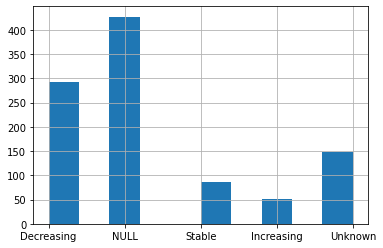

In [49]:
temp_iucn = iucn_data.copy()
temp_iucn.loc[temp_iucn['trend'].isna(), 'trend'] = 'NULL'
temp_iucn['trend'].hist()

In [55]:
print(
    'The dataset contains {} entries with available trend information (not Null or Unknown).'
    .format(
        len(iucn_data[(iucn_data['trend'].isna() == False)
                      & (iucn_data['trend'] != 'Unknown')])))

The dataset contains 431 entries with available trend information (not Null or Unknown).


**NOTE: This is an issue and we have to think about a strategy how to deal with these missing/unknown values.**
Maybe we can check if these entries have some special characteristics.

# Country Characteristics Data

## Load and Merge

In [97]:
coun_list = []
country_sets = []
for file in PATHS_COUN:
    print(file)
    temp = pd.read_csv(file)
    coun_list.append(temp)
    country_sets.append(set(temp['Country']))

data/OECD/protected_areas_2020.csv
data/OECD/LAND_COVER_2018_DATA.csv
data/climate/climate_features.csv


In [98]:
intersect_countries = country_sets[0].intersection(
    country_sets[1], country_sets[2])  ## add country_sets[3]
print(
    'The Country Characterisitcs Datasets contain {} intersecting countries, which are: {}'
    .format(len(intersect_countries), intersect_countries))

The Country Characterisitcs Datasets contain 29 intersecting countries, which are: {'Canada', 'Czech Republic', 'Poland', 'Mexico', 'Hungary', 'Denmark', 'Finland', 'France', 'Germany', 'Portugal', 'United States', 'Luxembourg', 'Netherlands', 'Australia', 'New Zealand', 'Norway', 'Sweden', 'Iceland', 'Belgium', 'Greece', 'Italy', 'Austria', 'Ireland', 'Slovak Republic', 'Japan', 'Korea', 'Switzerland', 'Spain', 'United Kingdom'}


--> Join Datasets on those countries.

In [103]:
coun_data = coun_list[0]
for coun in coun_list[1:]:
    coun_data = pd.merge(coun_data, coun, on='Country', how='inner')
coun_data.head()

,Country,perc_area_protected_all_obj,perc_area_protected_obj_2,perc_area_protected_obj_3,perc_area_protected_obj_4,perc_area_protected_obj_1a,perc_area_protected_obj_1b,perc_area_protected_no_obj,perc_area_protected_obj_5,perc_area_protected_obj_6,...,Cropland,Grassland,Inland water,Shrubland,Sparse vegetation,Tree cover,Wetland,temp_slope,gain_percentage,temp_difference
0,Australia,19.20,4.17,0.24,0.27,2.01,0.57,0.34,0.98,10.63,...,8.178167,16.812555,0.164372,21.624848,35.713072,11.719764,1.304020,0.017804,0.647408,0.143372
1,Austria,28.54,2.38,0.01,5.80,0.01,0.12,4.62,15.35,0.20,...,22.970504,15.325461,0.823728,0.000000,1.404353,53.686462,0.149325,0.038525,25.625767,1.583982
2,Belgium,24.97,0.07,0.00,1.54,0.00,0.00,9.19,12.59,1.59,...,50.669732,14.653097,0.520342,0.000000,0.011356,22.459738,0.335371,0.028670,11.555841,1.120281
3,Canada,11.02,6.26,0.02,0.36,0.10,3.68,0.24,0.01,0.35,...,5.803682,2.433807,10.524406,4.008505,23.335361,47.023071,0.812998,0.037969,-11.422166,0.748003
4,Czech Republic,21.91,1.06,0.33,0.98,0.04,0.04,5.16,14.29,0.00,...,49.813524,7.702887,0.752769,0.000000,0.059739,37.128373,0.098584,0.047428,20.827909,1.616906


## Analysis

### General Information

In [104]:
coun_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29 entries, 0 to 28
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Country                      29 non-null     object 
 1   perc_area_protected_all_obj  29 non-null     float64
 2   perc_area_protected_obj_2    29 non-null     float64
 3   perc_area_protected_obj_3    29 non-null     float64
 4   perc_area_protected_obj_4    29 non-null     float64
 5   perc_area_protected_obj_1a   29 non-null     float64
 6   perc_area_protected_obj_1b   29 non-null     float64
 7   perc_area_protected_no_obj   29 non-null     float64
 8   perc_area_protected_obj_5    29 non-null     float64
 9   perc_area_protected_obj_6    29 non-null     float64
 10  Artificial surfaces          29 non-null     float64
 11  Bare area                    29 non-null     float64
 12  Cropland                     29 non-null     float64
 13  Grassland             

There are no missing values in the dataset.

In [107]:
coun_data.describe()

,perc_area_protected_all_obj,perc_area_protected_obj_2,perc_area_protected_obj_3,perc_area_protected_obj_4,perc_area_protected_obj_1a,perc_area_protected_obj_1b,perc_area_protected_no_obj,perc_area_protected_obj_5,perc_area_protected_obj_6,Artificial surfaces,...,Cropland,Grassland,Inland water,Shrubland,Sparse vegetation,Tree cover,Wetland,temp_slope,gain_percentage,temp_difference
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,...,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,23.253103,3.889655,0.487931,2.984828,0.362759,1.116207,7.424483,5.810690,1.127931,3.342084,...,31.847605,15.385389,2.619700,4.000765,4.567584,33.671490,1.980374,0.033698,12.436452,0.935549
std,9.960634,6.553768,2.306550,3.487702,0.616244,2.073889,7.692362,6.637736,2.689496,2.915405,...,21.239388,16.477362,2.904174,8.584436,10.123313,18.027817,3.287130,0.012586,10.468157,0.508445
min,10.270000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.150601,0.164372,0.000000,0.008942,0.027662,0.008942,0.006156,-11.422166,0.124179
25%,14.550000,0.620000,0.000000,0.530000,0.000000,0.000000,0.510000,0.500000,0.000000,1.091316,...,9.221134,5.281011,0.823728,0.000000,0.039448,22.459738,0.108443,0.026566,6.251693,0.593730
50%,21.360000,1.680000,0.020000,0.980000,0.060000,0.040000,4.620000,2.910000,0.000000,2.883758,...,35.681073,7.769454,1.478442,0.115418,0.446822,32.244888,0.324014,0.034578,11.555841,0.834188
75%,27.980000,4.170000,0.070000,5.800000,0.460000,1.040000,11.460000,8.060000,0.370000,4.440102,...,49.813524,18.239015,2.364752,1.986954,2.091680,43.668692,1.438850,0.038715,20.634348,1.227504
max,51.370000,32.610000,12.470000,14.740000,2.180000,7.530000,30.510000,25.240000,10.630000,11.333710,...,72.813143,67.271091,10.524406,35.249425,35.731269,71.498391,12.347256,0.057306,38.881254,1.989826


In [115]:
coun_data['Country'].nunique()

29

# Full Data

## Merge both datasets

### Check Keys (countries)

In [121]:
iucn_countries = set(iucn_data['Country'].unique())
char_countries = set(coun_data['Country'].unique())
print('IUCN \ CHAR: {}'.format(iucn_countries.difference(char_countries)))
print('CHAR \ IUCN: {}'.format(char_countries.difference(iucn_countries)))

IUCN \ CHAR: {'New_Zealand', 'Slovakia', 'United_Kingdom', 'United_States', 'Czechia', 'Korea,_Republic_of'}
CHAR \ IUCN: {'New Zealand', 'Slovak Republic', 'United States', 'Czech Republic', 'Korea', 'United Kingdom'}


### Rename Country Data to Match IUCN Data

In [130]:
coun_data.loc[coun_data['Country'] == 'New Zealand', 'Country'] = 'New_Zealand'
coun_data.loc[coun_data['Country'] == 'Slovak Republic', 'Country'] = 'Slovakia'
coun_data.loc[coun_data['Country'] == 'United Kingdom', 'Country'] = 'United_Kingdom'
coun_data.loc[coun_data['Country'] == 'United States', 'Country'] = 'United_States'
coun_data.loc[coun_data['Country'] == 'Czech Republic', 'Country'] = 'Czechia'
coun_data.loc[coun_data['Country'] == 'Korea', 'Country'] = 'Korea,_Republic_of'

### Merge 

In [131]:
full_data = iucn_data.merge(coun_data, on='Country', how='inner')
full_data['Country'].nunique()

29